# Exploring NYC's CitiBike data

## Table of Contents
* [Introduction](#Introduction)
* [Methods](#Methods)
* [Getting the data](#Getting_the_data)
* [Analysis](#Analysis)
 

Questions to answer: 
    1. Top 5 stations with the most starts (showing # of starts)
    2. Trip duration by user type
    3. Most popular trips based on start station and stop station)
    4. Rider performance by Gender and Age based on avg trip distance (station to station), 
       median speed (trip duration / distance traveled)
    5. What is the busiest bike in NYC in 2017? How many times was it used? How many minutes was it in use?
    6. A model that can predict how long a trip will take given a starting point and destination. 


<a id='Introduction'></a>
## Introduction

CitiBike's data sharing information can be found at their [System Data website](https://www.citibikenyc.com/system-data). They provide information about the data set, such as included variables and their description. The data have been pre-cleaned before uploading, for example by removing trips taken by staff and any trips below 60 seconds in length. This means the data should be ready to use with no need for additional cleaning.

The data are organized in monthly subsets (each in its own '.csv' file) and are available since July 2013, soon after citibike service started, up until September 2018. Using data from one whole year is probably the most appropriate, as there may be yearly patterns. Also, this will provide a good amount of observations, enough for most analysis we may want to do. For this exercise I will thus use all 2017 data, as this is the only full year available so far.

The data are hosted on and can be downloaded from Amazon Simple Storage Service (Amazon S3).

<a id='Methods'></a>
## Methods

This data analysis was made on a MacBook Pro laptop. Besides the shell (Bash), I used the following tools in [Python](https://www.python.org/):

* [Pandas](http://pandas.pydata.org/) for data manipulation.
* [Folium](http://folium.readthedocs.org/en/latest/) for mapping.


<a id='Getting_the_data'></a>
## Getting the data

I will use the shell (bash in this case) to get the data. Download the files using `curl` and then unzip them and remove the zipped versions.

In [49]:
# Add `!` preceding the command to run shell commands
# Curl accepts ranges
!curl -O "https://s3.amazonaws.com/tripdata/2017[01-12]-citibike-tripdata.csv.zip"
!unzip '*.zip'
!rm *.zip


[1/12]: https://s3.amazonaws.com/tripdata/201701-citibike-tripdata.csv.zip --> 201701-citibike-tripdata.csv.zip
--_curl_--https://s3.amazonaws.com/tripdata/201701-citibike-tripdata.csv.zip
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 23.1M  100 23.1M    0     0  14.4M      0  0:00:01  0:00:01 --:--:-- 14.4M

[2/12]: https://s3.amazonaws.com/tripdata/201702-citibike-tripdata.csv.zip --> 201702-citibike-tripdata.csv.zip
--_curl_--https://s3.amazonaws.com/tripdata/201702-citibike-tripdata.csv.zip
100 25.1M  100 25.1M    0     0  18.5M      0  0:00:01  0:00:01 --:--:-- 21.4M

[3/12]: https://s3.amazonaws.com/tripdata/201703-citibike-tripdata.csv.zip --> 201703-citibike-tripdata.csv.zip
--_curl_--https://s3.amazonaws.com/tripdata/201703-citibike-tripdata.csv.zip
100 23.0M  100 23.0M    0     0  18.1M      0  0:00:01  0:00:01 --:--:-- 20.2M

[4/12]: https://s3.amazonaws.com/t

The next step is to load the data with Pandas. I will use a `for loop` to read all 12 csv files into a list of Pandas *DataFrames*.

In [50]:
# Get file names
import glob
filenames = glob.glob('*.csv')
print(filenames)

['201709-citibike-tripdata.csv', '201701-citibike-tripdata.csv', '201703-citibike-tripdata.csv', '201705-citibike-tripdata.csv', '201711-citibike-tripdata.csv', '201707-citibike-tripdata.csv', '201708-citibike-tripdata.csv', '201702-citibike-tripdata.csv', '201704-citibike-tripdata.csv', '201712-citibike-tripdata.csv', '201706-citibike-tripdata.csv', '201710-citibike-tripdata.csv']


The below code will:
* Loop through each data file we downloaded.
* Read the file into a Pandas DataFrame.
* Put each DataFrame into a Python dictionary.

In [75]:
import pandas as pd
# Loop through file names and read the data
dfs = []
for f in filenames:
    print('Reading ' + f)
    #d = pd.read_csv(f)
    #dfs[f.replace('-citibike-tripdata.csv', '')] = d
    dfs.append(pd.read_csv(f))

Reading 201709-citibike-tripdata.csv
Reading 201701-citibike-tripdata.csv
Reading 201703-citibike-tripdata.csv
Reading 201705-citibike-tripdata.csv
Reading 201711-citibike-tripdata.csv
Reading 201707-citibike-tripdata.csv
Reading 201708-citibike-tripdata.csv
Reading 201702-citibike-tripdata.csv
Reading 201704-citibike-tripdata.csv
Reading 201712-citibike-tripdata.csv
Reading 201706-citibike-tripdata.csv
Reading 201710-citibike-tripdata.csv


Once we've read the data in, we can use the head method on DataFrames to print the first 3 lines and number of entries and columnnames of each DataFrame :

In [78]:
for i in range(12):
    print('\n*Reading dataframe ',i)
    print(dfs[i].head(3))
    print(dfs[i].shape)
    print(dfs[i].columns,'\n')


*Reading dataframe  0
   tripduration            starttime             stoptime  start station id  \
0           362  2017-09-01 00:00:17  2017-09-01 00:06:19              3331   
1           188  2017-09-01 00:00:21  2017-09-01 00:03:30              3101   
2           305  2017-09-01 00:00:25  2017-09-01 00:05:30              3140   

        start station name  start station latitude  start station longitude  \
0  Riverside Dr & W 104 St               40.801343               -73.971146   
1    N 12 St & Bedford Ave               40.720798               -73.954847   
2          1 Ave & E 78 St               40.771404               -73.953517   

   end station id          end station name  end station latitude  \
0            3328  W 100 St & Manhattan Ave             40.795000   
1            3100    Nassau Ave & Newell St             40.724813   
2            3141           1 Ave & E 68 St             40.765005   

   end station longitude  bikeid    usertype  birth year  gender  

The Dataframes don't have the same column names. The code below will uniform all the columns and concat them into one datafame:

In [86]:
for i in range (11):
    dfs[i].columns = dfs[11].columns
    #dfs[i].rename(columns=dict(zip(old_names, new_names)), inplace=True)
    #print(dfs[i].columns)
    

In [89]:
results = pd.concat(dfs[i] for i in range(12))
print(results.shape)

(16364657, 15)


In [90]:
results.dtypes

tripduration                 int64
starttime                   object
stoptime                    object
start station id             int64
start station name          object
start station latitude     float64
start station longitude    float64
end station id               int64
end station name            object
end station latitude       float64
end station longitude      float64
bikeid                       int64
usertype                    object
birth year                 float64
gender                       int64
dtype: object

Indeed, there's an important format difference: the `starttime` and `stoptime` variables uhave object formats. This will be important later on as we use these timestamps for the analyses.

There are several ways we can fix this. The most convenient way to use time series data is to convert it to the appropriate data type (pandas uses NumPy's `datetime64`). I will use the function `to_datetime` to do this. `to_datetime` is very flexible and will recognize a wide variety of string formats.

In [147]:
#results['starttime'] = pd.to_datetime(results['starttime'])
#results['stoptime'] = pd.to_datetime(results['stoptime'])
#results.dtypes

In [103]:
df = results # make a copy in case we need it for later

In [94]:
# Remove .csv files as we no longer need them before saving the data frame as cvs file
#!rm *.csv

Now that the timestamps are consistent, I can save the dataframe.

In [97]:
#Saved csv to avoid running code above multiple times in the future
results.to_csv('2017-citibike-data.csv',index=False, )

<a id='Analysis'></a>
## Analysis

Get an overview of the data, by looking at the general aspect of the variables, data types, total number of observations, and so on.

**Ask:** <br />
    1. Top 5 stations with the most starts (showing # of starts)
    2. Trip duration by user type
    3. Most popular trips based on start station and stop station)
    4. Rider performance by Gender and Age based on avg trip distance (station to station), 
       median speed (trip duration / distance traveled)
    5. What is the busiest bike in NYC in 2017? How many times was it used? How many minutes was it in use?
    6. A model that can predict how long a trip will take given a starting point and destination. 

In [164]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
import datetime as dt
plt.style.use('ggplot')
%matplotlib inline

In [102]:
#file_name = '2017-citibike-data.csv'
#df = pd.read_pickle(file_name) # Read data and print elapsed time

### Part 1: Top 5 Stations 
Let's check if there's any noise or cleanup which needs to be done before creating the chart. <br />
1. Any missing values?<br />
    - Mostly for Birth year and a few for User Type. We can ignore these for now and deal with them later.<br />
2. Let's get the data in the right format<br />
    - Trip Duration - Int<br />
    - Start Time - DateTime<br />
    - Stop Time - DateTime<br />
    - Start Station ID - Categorical<br />
    - Start Station Name - Categorical<br />
    - User Type - Categorical<br />
    - Birth Year - Ordinal<br />
    - Gender - Categorical<br />
3. Deal with trips which lasted less than 1.5 minute (90 seconds). If so, in the ideal world, we should not include this start, we may double count. If a bike is broken, a user will dock it again within a minute or two and pick-up another one.<br />
   - Would be ideal to not include any starts where a tip lasted less than 90 seconds *and* the start station = end station.<br /> 
4. Anomalies such as theft and broken docks shouldn't matter for this metric and can be dealth with later.

In [167]:
print('Number of individual bikes: ',df['bikeid'].nunique())
print('Number of citibike stations: ',df['start station id'].nunique())

Number of individual bikes:  14203
Number of citibike stations:  811


In [150]:
#Percentage of missing data.
def missing_data(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    print('Missing data')
    return missing_data
missing_data(df)

Missing data


,Total,Percent
birth year,1630335,9.962537
usertype,15909,0.097216
gender,0,0.000000
bikeid,0,0.000000
end station longitude,0,0.000000
end station latitude,0,0.000000
end station name,0,0.000000
end station id,0,0.000000
start station longitude,0,0.000000
start station latitude,0,0.000000


In [146]:
df.dtypes

tripduration                        int64
starttime                  datetime64[ns]
stoptime                   datetime64[ns]
start station id                    int64
start station name                 object
start station latitude            float64
start station longitude           float64
end station id                      int64
end station name                   object
end station latitude              float64
end station longitude             float64
bikeid                              int64
usertype                           object
birth year                        float64
gender                              int64
dtype: object

In [149]:
#Ensure data is formatted correctly to avoid errors in the visuals
#df['starttime'] = pd.to_datetime(df['starttime'])
#df['stoptime'] = pd.to_datetime(df['stoptime'])
df['start station name'] = df['start station name'].astype('category')
df['end station id'] = df['end station id'].astype('category')
df['usertype'] = df['usertype'].astype('category')
df['gender'] = df['gender'].astype('category')
round(df.describe(),2)

,tripduration,start station id,start station latitude,start station longitude,end station latitude,end station longitude,bikeid,birth year
count,16364657.00,16364657.00,16364657.00,16364657.00,16364657.00,16364657.00,16364657.00,14734322.00
mean,994.59,1357.13,40.74,-73.98,40.74,-73.98,23754.63,1978.90
std,16178.92,1346.90,0.07,0.12,0.05,0.08,5345.62,11.83
min,61.00,72.00,0.00,-74.03,0.00,-74.09,14529.00,1858.00
25%,372.00,361.00,40.72,-74.00,40.72,-74.00,18653.00,1971.00
50%,621.00,487.00,40.74,-73.99,40.74,-73.99,25464.00,1982.00
75%,1076.00,3142.00,40.76,-73.98,40.76,-73.98,28114.00,1988.00
max,9735948.00,3654.00,45.51,0.00,45.51,0.00,33481.00,2001.00


In [156]:
#Quasi Confirm Hypothesis in point #3
df_bikenum = pd.DataFrame()
df_bikenum['First Bike'] = df[df['tripduration'] < 90]['start station name'] 
df_bikenum['Second Bike'] = df[df['tripduration'] < 90]['end station name']
df_bikenum.head()

,First Bike,Second Bike
starttime,,
2017-09-01 00:26:14,S 5 Pl & S 4 St,S 5 Pl & S 4 St
2017-09-01 00:29:27,Amsterdam Ave & W 66 St,W 67 St & Broadway
2017-09-01 01:31:39,W 76 St & Columbus Ave,Columbus Ave & W 72 St
2017-09-01 01:40:39,Hoyt St & Warren St,Hoyt St & Warren St
2017-09-01 01:50:10,Allen St & Stanton St,Stanton St & Chrystie St


In [157]:
#Clear up enviornment and drop double count
del(df_bikenum)
df = df.drop(df.index[(df['tripduration'] < 90) & 
                          (df['start station latitude'] == df['end station latitude'])])

In [158]:
#Data for Top 5 Stations visual
top5 = pd.DataFrame() 
top5['Station']=df['start station name'].value_counts().head().index
top5['Number of Starts']=df['start station name'].value_counts().head().values
top5['Station'] = top5['Station'].cat.remove_unused_categories()
top5['Station'] = top5['Station'].astype('object')
#top5.sort_values(by = 'Number of Starts', ascending = False)

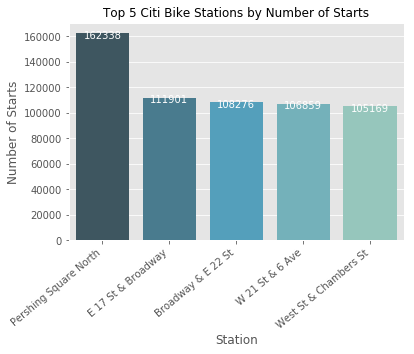

In [165]:
#Plot for Part 1: Top 5 Stations
ax = sns.barplot('Station', 'Number of Starts', data = top5, palette="GnBu_d")
ax.set_title('Top 5 Citi Bike Stations by Number of Starts', fontsize = 12)
rcParams['figure.figsize'] = 12,7
ax.set_xticklabels(ax.get_xticklabels(),rotation=40, ha = 'right')
for index, row in top5.iterrows():
    ax.text(index,row['Number of Starts']-4000,row['Number of Starts'], 
            color='white', ha="center", fontsize = 10)
plt.show()

### Part 2: Trip Duration by User Type
This question is a bit unclear in terms of what to do with the anomalies, so I'll be making two graphs. One with anomalies, one without.<br />

*There are NA values in the dataset for usertype as can be seen from missing_table. Since it's only 0.09% of the data, it's safe to remove.*<br />

**According to Citi Bikes' website:** The first 45 minutes of each ride is included for Annual Members, and the first 30 minutes of each ride is included for Day Pass users. If you want to keep a bike out for longer, it’s only an extra $4 for each additional 15 minutes.<br />

It's safe to assume, no one (or very few people) will be willing to rent a bike for more than 2 hours, especially a clunky citibike. If they did, it would cost them an additional $20 assuming they're annual subscribers. It would be more economical for them to buy a bike if they want that workout or use one of the tour bikes in central park if they want to tour and explore the city on a bike. There may be a better way to choose an optimal cutoff, however, time is key in a client project. Or just docing and getting another bike. The real cost of a bike is accrued ~24 hours. <br />

**Anomalies**: Any trip which lasts longer than 2 hours (7,200 seconds) probably indicates a stolen bike, an anomaly, or incorrect docking of the bike. As an avid Citibike user, I know first hand that it doesn't make any sense for one to use a bike for more than one hour! However, I've added a one hour cushion just in case. No rider would plan to go over the maximum 45 minutes allowed. However, I wplan to reduce this to one hour in the future for modelling purposes. 

1. *First Half- with anomalies in dataset*
    - The graph under ax2 is a bargraph of average trip duration for each user type. It's helpful, but would be better to see a boxplot and get an idea of the distribution and see mintues instead of seconds.<br />
    - Second graph is a basic Boxplot based with anomalies included. As we can see, there is too much noise for this to be useful. It'll be better to look at this without anomalies.<br />

2. *Second Half - without anomalies in dataset*
    - Still not useful, let's add a column with minutes for trip Duration.<br />
    - Boxplot with minutes is much more useful. There are still some outliers, however, it is informative. 

First, let's just see the trip duration alone

Text(0,0.5,'Trip counts')

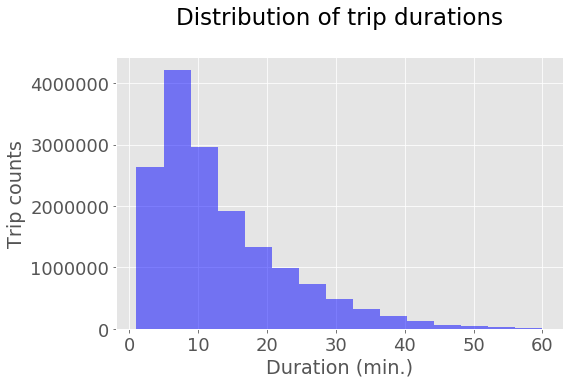

In [187]:
# Collect all trips shorter than 1 hour
duration_mins = df.loc[(df.tripduration / 60 < 60)][['tripduration']]
duration_mins = duration_mins / 60 # In minutes

# Plot the distribution of trip durations
plt.rcParams.update({'font.size': 16})
duration_mins.hist(figsize = (8,5), bins = 15, alpha = 0.5, color = 'blue')
plt.tick_params(axis = 'both', which = 'major', labelsize = 18)
plt.title('Distribution of trip durations\n')
plt.xlabel('Duration (min.)')
plt.ylabel('Trip counts')

The histogram shows that most trips are rather short. As duration increases the number of trips gets smaller and long trips are not very frequent.

There are many interesting questions to explore using these data. In this analysis I will be focusing on comparing the different citibike stations in the network according to number of trips and their duration. The final goal is to build visualizations of total trip counts and trip duration on maps of the citibike station network.

#### Temporal patterns of citibike use

Text(0,0.5,'Number of trips')

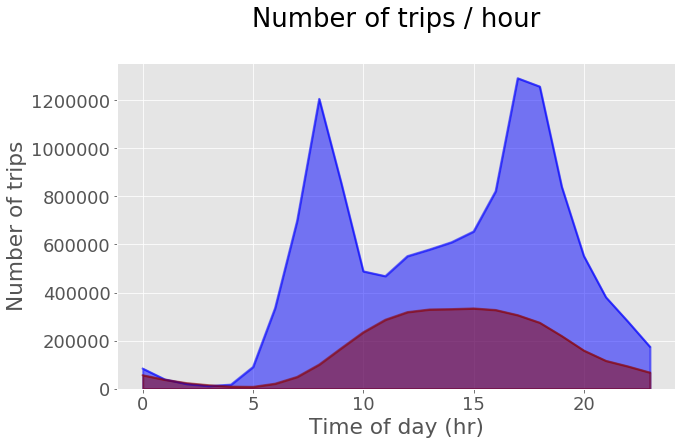

In [188]:
# Calculate trip counts per hour on weekdays and weekends
df_sub = df.loc[:, ['tripduration', 'starttime']] # Keep only 'starttime' and 'tripduration' variables
# Index dataframe by 'datetime64' data in 'starttime' variable
df_sub.index = df_sub['starttime']
weekdays = df_sub[df_sub.index.weekday < 5]
weekends = df_sub[df_sub.index.weekday > 4]
weekdays_countsPerHr = weekdays.groupby(weekdays.index.hour).size()
weekends_countsPerHr = weekends.groupby(weekends.index.hour).size()


plt.rcParams.update({'font.size': 18, 'legend.fontsize': 20})
weekdays_countsPerHr.plot(kind = 'area', stacked = False, figsize = (10, 6), color = 'blue',
                          linewidth = 2, label='Weekdays')

weekends_countsPerHr.plot(kind = 'area', stacked = False, color = 'darkred',
                          linewidth = 2, label='Weekends')

plt.tick_params(axis = 'both', which = 'major', labelsize = 18)
#ax = plt.gca()
plt.title('Number of trips / hour\n')
plt.xlabel('Time of day (hr)')
plt.ylabel('Number of trips')
#legend = ax.legend(loc='upper left', frameon = False)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)
  


Text(0,0.5,'Number of trips')

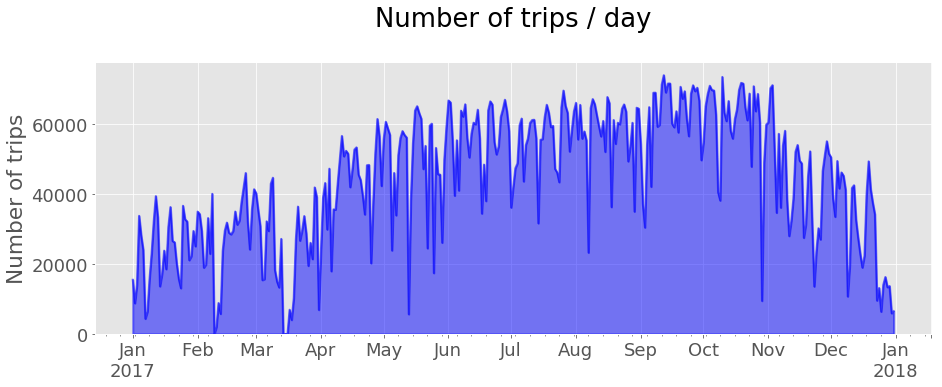

In [189]:
df.index = df['starttime']
countsPerDay = df.starttime.resample('D', how = ['count'])


countsPerDay.plot(kind = 'area', stacked = False, figsize = (15, 5),
                  color = 'blue', linewidth = 2, legend = False)
plt.tick_params(axis = 'both', which = 'major', labelsize = 18)
#ax = plt.gca()
plt.title('Number of trips / day\n')
plt.xlabel('')
plt.ylabel('Number of trips')

In [170]:
#del(top5)
#Drop NA Usertype
df = df.dropna(subset=['usertype']) 

In [172]:
#Calculate trip duration
TD_user = pd.DataFrame()
TD_user['Avg. Trip Duration'] = round(df.groupby('usertype')['tripduration'].mean(),2)
TD_user = TD_user.reset_index()
TD_user['usertype'] = TD_user['usertype'].astype('object')

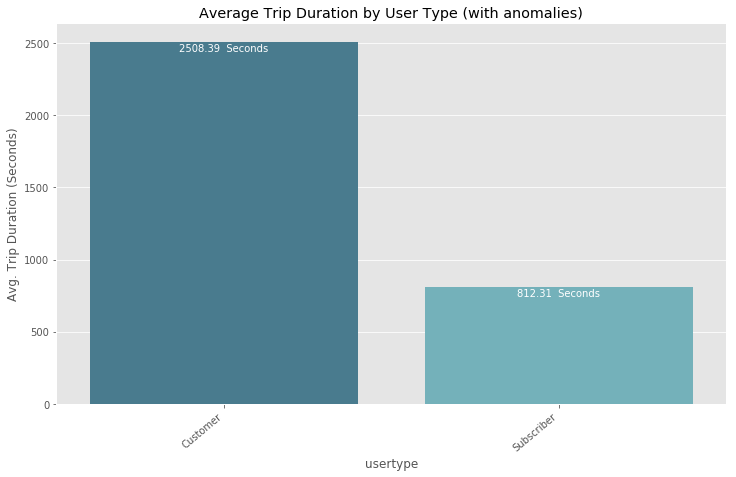

In [174]:
#Average trip Duration per User Type with Anomalies
ax2 = sns.barplot('usertype', 'Avg. Trip Duration', data = TD_user,palette="GnBu_d")
ax2.set_title('Average Trip Duration by User Type (with anomalies)')
#rcParams['figure.figsize'] = 12,7
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=40, ha = 'right')
ax2.set_ylabel('Avg. Trip Duration (Seconds)')
for index, row in TD_user.iterrows():
    ax2.text(index,row['Avg. Trip Duration']-70,(str(row['Avg. Trip Duration'])+"  Seconds"), 
             color='white', ha="center", fontsize = 10)
plt.show()

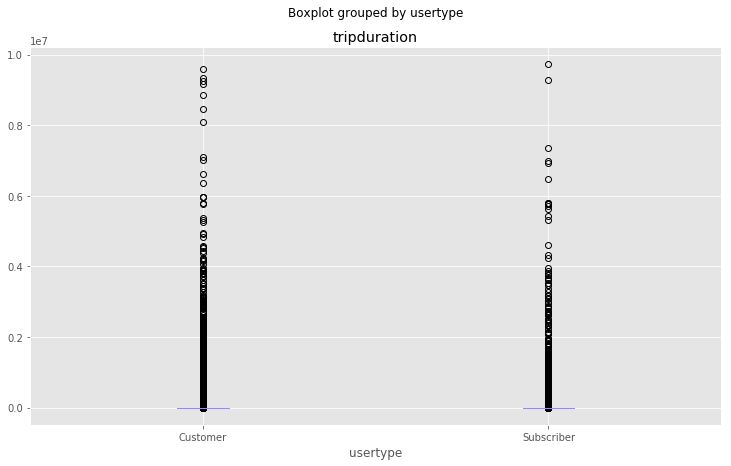

In [175]:
#Boxplots are more informative to visualize breakdown of data
del(TD_user)
df.boxplot('tripduration', by = 'usertype')
plt.show()

In [176]:
#Remove anomalies based on definition above
df = df.drop(df.index[(df['tripduration'] > 7200)])

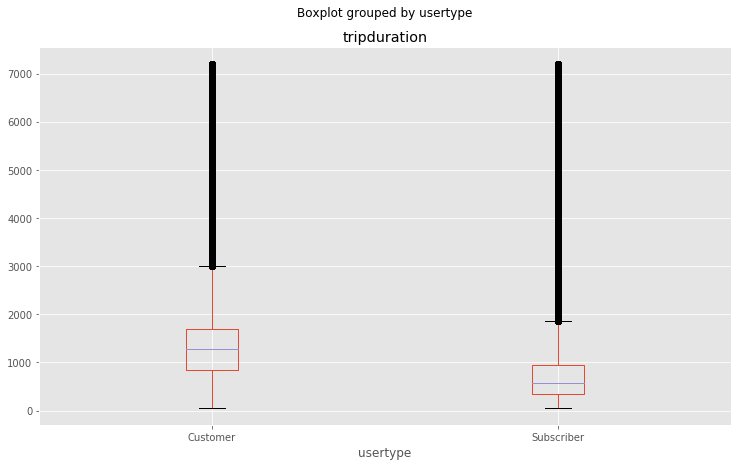

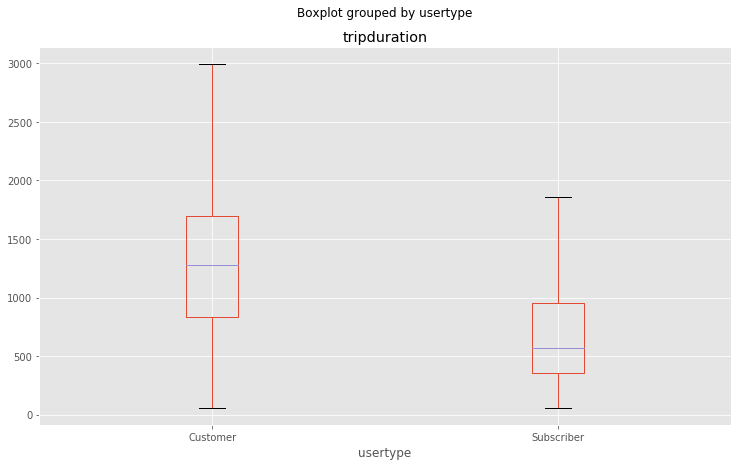

In [177]:
#Boxplots are more informative to visualize breakdown of data
df.boxplot('tripduration', by = 'usertype')
plt.show()
#Boxplot without outliers
df.boxplot('tripduration', by = 'usertype',showfliers=False)
plt.show()

In [178]:
#Add Minutes column for Trip Duration
df['Minutes'] = df['tripduration']/60
#For Visual purposes, rounded
df['Minutes'] = round(df['Minutes'])
df['Minutes'] = df['Minutes'].astype(int)

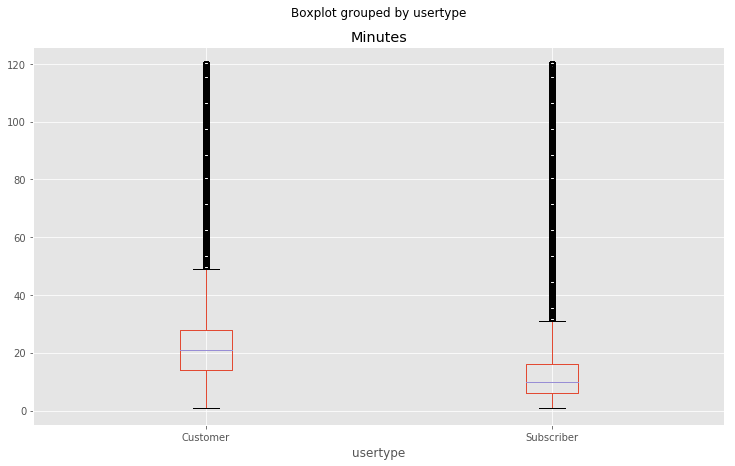

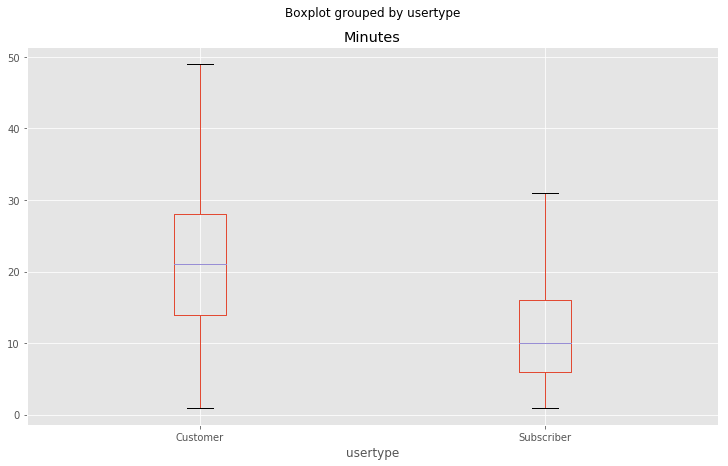

In [179]:
#Final Boxplot with some outliers. Could turn of outliers with showfliers = False
df.boxplot('Minutes', by = 'usertype')
plt.show()
df.boxplot('Minutes', by = 'usertype', showfliers = False)
plt.show()

In [181]:
TD_user2 = pd.DataFrame()
TD_user2['Avg. Trip Duration'] = round(df.groupby('usertype')['Minutes'].mean(),1)
TD_user2 = TD_user2.reset_index()
TD_user2['usertype'] = TD_user2['usertype'].astype('object')

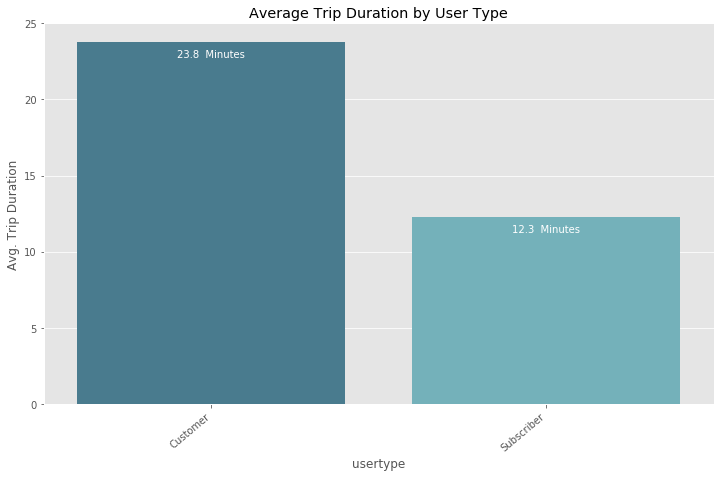

In [182]:
#Average Trip Duration Based on Minutes
ax3 = sns.barplot('usertype', 'Avg. Trip Duration', data = TD_user2,palette="GnBu_d")
ax3.set_title('Average Trip Duration by User Type')
#rcParams['figure.figsize'] = 12,10
ax3.set_xticklabels(ax3.get_xticklabels(),rotation=40, ha = 'right')
for index, row in TD_user2.iterrows():
    ax3.text(row.name,row['Avg. Trip Duration']-1,(str(row['Avg. Trip Duration'])+"  Minutes"), 
             color='white', ha="center", fontsize = 10)
plt.show()

In [183]:
del(TD_user2)
#Undo rounding for modelling purposes
df['Minutes'] = df['tripduration']/60

### Part 3: Most Popular Trip
To get most popular trips, the most convenient way to do this is by using the groupby function in pandas. It's analogous to a Pivot table. <br />

The groupby function makes it extremely easy and convenient to identify the most popular trips. Visuals and transformations can be found below.<br />

In [184]:
#Identify the 10 most popular trips
trips_df = pd.DataFrame()
trips_df = df.groupby(['start station name','end station name']).size().reset_index(name = 'Number of Trips')
trips_df = trips_df.sort_values('Number of Trips', ascending = False)
trips_df['start station name'] = trips_df['start station name'].astype(str)
trips_df["end station name"] = trips_df["end station name"].astype(str)
trips_df['Trip'] = trips_df['start station name'] + " to " + trips_df['end station name']
trips_df = trips_df[:10]
trips_df = trips_df.drop(['start station name', "end station name"], axis = 1)
trips_df = trips_df.reset_index()
#trips_df.head()

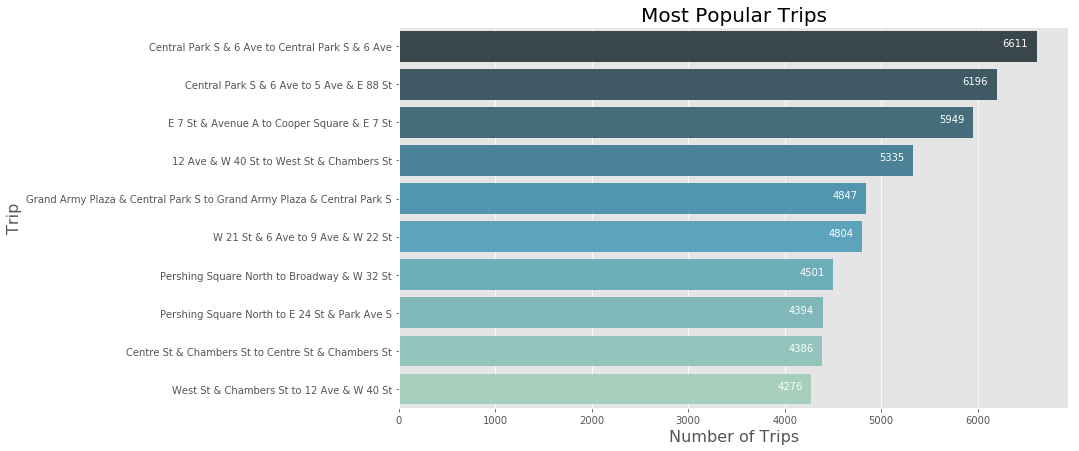

In [185]:
ax4 = sns.barplot('Number of Trips','Trip', data = trips_df,palette="GnBu_d")
ax4.set_title('Most Popular Trips', fontsize = 20)
ax4.set_ylabel("Trip",fontsize=16)
ax4.set_xlabel("Number of Trips",fontsize=16)
for index, row in trips_df.iterrows():
    ax4.text(row['Number of Trips']-220,index,row['Number of Trips'], 
             color='white', ha="center",fontsize = 10)
plt.show()

### Part 4: Rider Performance by Gender and Age

**Ask:** Rider performance by Gender and Age based on avg trip distance (station to station), median speed (trip duration/distance traveled)<br />

Let's make sure the data we're working with here is clean.<br />

1. Missing Gender and Birth Year values - Check missing_table above
    - No for Gender. Yes for Birth Year
    - ~10% Missing Birth year. Not a big chunk of data. Can either impute missing values or drop it. Since it's less                                         than 10% of the data, it's safe to assume the rest of the 90% is a representative sample of data and we can replace the birth year with the median, based on gender and Start Station ID. I chose this method because most people the same age live in similar neighborhoods (i.e: young people in east village, older people in Upper West Side, etc.). This will be done after anomalies are removed and speed is calculated.
2. Are there anomalies?
    - For Birth Year, there are some people born prior to 1956. I can believe some 60 year olds can ride a bike and that's a stretch, however, anyone "born" prior to that riding a citibike is an anomaly and false data. There could be a few senior citizens riding a bike, but probably not likely.
    - My approach is to identify the age 2 standard deviations lower than the mean. After calculating this number, mean-2stdev, I removed the tail end of the data, birth year prior to 1956.
3. Caulculate an Age column to make visuals easier to interpret.
4. Calculate trip distance (Miles)
    - No reliable way to calculate bike route since we can't know what route a rider took without GPS data from each bike. 
    - Could use Google maps and use lat,long coordinates to find bike route distance. However, this would require more than the daily limit on API calls. Use the geopy.distance packge which uses Vincenty distance uses more accurate ellipsoidal models. This is more accurate than Haversine formula, but doesn't matter much for our purposes.
5. Caulculate Speed (min/mile) and (mile/hr)
    - (min/mile): Can be used like sprint time (how fast does this person run)
    - (mile/hr): Conventional approach. Miles/hour is an easy to understand unit of measure and one most people are used to seeing. So the visual will be created based on this understanding.
6. Dealing with "circular" trips
    - Circular trips are trips which start and end at the same station. The distance for these trips will come out to 0, however, that is not the case. These points will skew the data and visuals. Will be removing them to account for this issue. 
    - For the model, this data is also irrelevant. Because if someone is going on a circular trip, the only person who knows how long the trip is going to take is therider themself, assuming they know that. So it's safe to drop this data for the model. <br />
7. Rename Gender Values in Legend from 0,1,2 to Unknown, Male, Female, respectively. 
    - The rows where Gender is unknown throws the visual off. There are a few ways to handle this: 
      - Remove the missing data. This would not result in a significant loss of information since only 58073 rows have gender as unknown.
       - We can impute missing values, however given the proportion of unknowns the information gain would be negligible.
       - Based on the reasons above, I've decided to remove data with unknown gender. These rows should not have a  significant imact on the predictive model later on. However, I will confirm this.
8. Determine Gender and Age performance based on Average Trip distance<br />
    - Similar to graphs for speed. Pretty straightforward.

In [190]:
del(trips_df)
#Drop the tail end of birth years 2 standard deviations below the mean
#df['Birth Year'].mean()-(2*df['Birth Year'].std())
df = df.drop(df.index[(df['birth year'] < 1956)])

In [191]:
#Combine coordinates to calculate distance based on Vincenty
df['Start Coordinates'] = list(zip(df['start station latitude'], 
                                   df['start station latitude']))
df['End Coordinates'] = list(zip(df['end station latitude'], 
                                 df['end station latitude']))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [196]:
#In the future, for a dataset of this size, I would consider using the Haversine formula to calculate distance 
#if it's faster.
#import geopy
#from geopy.distance import vincenty
#dist = []
#for i in range(len(df)):
#    dist.append(geopy.distance.vincenty(df.iloc[i]['Start Coordinates'],df.iloc[i]['End Coordinates']).miles)
#    if (i%1000000==0):
#        print(i)

#Code above takes a long time to run, use Distance.csv file instead
dist = pd.read_csv('Distance.csv', header = None)
dist = dist.drop([0], axis = 1)

In [ ]:
#Reset Index to avoid issues in future calculations
df = df.reset_index()
df = df.drop('index',axis =1)
df['Distance'] = dist

In [ ]:
del(dist)
#Replace missing birth year by median based on speed and gender
df['birth year'] = df.groupby(['gender','start station id'])['birth year'].transform(lambda x: x.fillna(x.median()))

In [ ]:
#Still have a few nulls, but it's only 2342 entries now. Comfortable dropping these.
df = df.dropna(subset=['birth year'])

#Calculate age and drop circular/roundtrips
df['Age'] = 2018 - df['birth year']
df['Age'] = df['Age'].astype(int)

df = df.drop(df.index[(df['Distance'] == 0)])

In [ ]:
#2. Followed the same reasoning as behind Birth Year. 
# People in similar locations tend to also work in a similar industry or location
df['Distance'] = df.groupby(['gender','start station id'])['Distance'].transform(lambda x: x.fillna(x.median()))


In [ ]:
df['min_mile'] = round(df['Minutes']/df['Distance'], 2)
df['mile_hour'] = round(df['Distance']/(df['Minutes']/60),2)

In [ ]:
round(df.describe(),2)

### Observations
- We still have trips less than 90 seconds, however they seem to be legitimate trips. Checked using the code in cell above. 
- We have some Start Coordinates as (0.0,0.0). These are trips which were taken away for repair or for other purposes. These should be dropped. If kept, the distance for these trips is 5,389 miles. For this reason I've dropped any points where the distance is greater than 30 miles. Additionally, we have some missing values. Since it's a tiny portion, let's replace missing values based on Gender and start location. These
- One some trips, the speed of the biker is more than 200 mph. This could be due to the formula used for distance calculation or some other error. The fastest cyclist in the world on a flat surface ever recorded biked at 82mph. It's safe to assume none of the citibike riders can approach this speed. Due to this and the fact that an average cyclist speed is 10mph, I've decided to remove all data where the speed in mph is greater than 20 mph and less than 0.1 mph. ~1.5k data points

In [ ]:
df = df[df['Distance'] < 30]

In [ ]:
#3.1-Done in two steps to ensure data integrity, could've used an or statement as well.
df = df[df['mile_hour']<20]
#3.2
df = df[df['mile_hour']> (df['mile_hour'].mean()-(2*df['mile_hour'].std()))]

In [ ]:
#Dropping unknown to make the visual more informative. 
#Unknown gender may be important for the model, which is why I created a copy of the original dataframe.
df1 = df.drop(df.index[(df['gender'] == 0)])

In [ ]:
#Rider performance by age and Gender in Min/Mile 
fig, ax5 = plt.subplots(figsize=(11,5))
df1.groupby(['Age','gender']).median()['min_mile'].unstack().plot(ax=ax5, color ="bg")
ax5.legend(['Female','Male'])
plt.ylabel('Median Speed (min/mile)')
plt.title('Rider Performance Based on Gender and Age (Median Speed in min/mile)')
plt.show()

In [ ]:
#Rider performance by age and Gender in Miles/hr
#del([fig,ax5])
fig1, ax6 = plt.subplots(figsize=(11,5))
df1.groupby(['Age','gender']).median()['mile_hour'].unstack().plot(ax=ax6,color ="bg")
ax6.legend(['Female', 'Male'])
plt.ylabel('Median Speed (miles/hr)')
plt.title('Rider Performance Based on Gender and Age (Median Speed in miles/hr)')
plt.show()

In [ ]:
#Rider performance by age and Gender in Averge Distance
#del([fig1,ax6])
fig2, ax7 = plt.subplots(figsize=(11,5))
df1.groupby(['Age','gender']).mean()['Distance'].unstack().plot(ax=ax7,color ="bg")
ax7.legend(['Female', 'Male'])
plt.ylabel('Average Distance (miles)')
plt.title('Rider Performance Based on Gender and Age (Average Distance in Miles)')
plt.show()

### Part 5: Busiest Bike by Times and Minutes Used
*Ask:* 
 1. What is the busiest bike in NYC in 2017? 
    - Bike 25738
 2. How many times was it used?
     - 2355 times
 3. How many minutes was it in use?
      - 31,340 Minutes

- Busiest bike and count can be identified by a groupby function
- Function above will also identify the number of times the bike was used
- A similar groupby function which calls for the sum on minutes can identify the number of minutes the bike was used. 

In [ ]:
#Bike usage based on number of times used
#del(df1)
bike_use_df = pd.DataFrame()
bike_use_df = df.groupby(['bikeid']).size().reset_index(name = 'Number of Times Used')
bike_use_df = bike_use_df.sort_values('Number of Times Used', ascending = False)
#bike_use_df.to_csv('Q5.csv')
bike_use_df = bike_use_df[:10]
bike_use_df['bikeid'] = bike_use_df['bikeid'].astype(str)
bike_use_df['bikeid'] = ('Bike ' + bike_use_df['bikeid'])
bike_use_df = bike_use_df.reset_index()
#bike_use_df.head()

In [ ]:
#Visual of most used bike based on Number of Trips
ax8 = sns.barplot('Number of Times Used', 'bikeid',data = bike_use_df, palette="GnBu_d")
ax8.set_title('Most Popular Bikes by Number of Times Used')
for index, row in bike_use_df.iterrows():
    ax8.text(row['Number of Times Used']-90,index,row['Number of Times Used'], color='white', ha="center", fontsize =10)
plt.show()

In [ ]:
#Bike usage based on minutes used
#del(ax8)
bike_min_df = pd.DataFrame()
bike_min_df['Minutes Used'] = df.groupby('bikeid')['Minutes'].sum()
bike_min_df = bike_min_df.reset_index()
bike_min_df = bike_min_df.sort_values('Minutes Used', ascending = False)
bike_min_df['bikeid'] = bike_min_df['bikeid'].astype(str)
bike_min_df['bikeid'] = ('Bike ' + bike_min_df['bikeid'])
bike_min_df = bike_min_df[:10]
bike_min_df = bike_min_df.reset_index()
#bike_min_df.head()

In [ ]:
#Visual of most used bike based on number of minutes used
ax9 = sns.barplot('Minutes Used', 'bikeid',data = bike_min_df, palette="GnBu_d")
ax9.set_title('Most Popular Bikes by Minutes Used')
rcParams['figure.figsize'] = 11,6
for index, row in bike_min_df.iterrows():
    ax9.text(row['Minutes Used']-2800,index,str(round(row['Minutes Used'],2))+' Minutes', 
             color='white', ha="center")
plt.show()

### Part 6.1: Predictive Model - Baseline Model
Ask: Build a model that can predict how long a trip will take given a starting 
     point and destination. 

***Assumptions on how the Kiosk will work:*** After speaking to Daniel Yawitz (if you're 
looking at this, thanks for the clarification), I was told that we should assume that when
a user inputs the start and end station, they swipe their key fob (if they're a subscriber)
and enter their info on the kiosk (if they're a "Customer") prior to entering the start 
and end station. This means that we would know their gender and age. Thus these variables
can be used in building the model.

Step 1.  
   - This dataset is massive. Almost 14 million rows. Let's work on a *random* subsample while we build and evaluate models. If I tried to build and evaluate a model on the entire dataset, each run would take me ~10+ minutes depending on the model. One good way to decide what portion of your data to work with is using a learning curve. However, my kernel keeps crashing while trying to create that learning curve. However, given the size of the data and from experience by working with senior data scientists on projects with BAML and other firms I know that I can comfortably work with a few thoushand rows of data given the fact that this is only one year of data. If we were working with data for multiple years, I'd need to reconsider this approach. However, given the reasons above, I've decided to sample 10% of the data. It's stil ~1.3 million rows and should be a representative sample since it's randomly selected. I'll be evaluating my model on df_sample.
  - I also made the same visuals on the sample to visualize the data.
          
          
Step 2. 
  - Let's get a baseline. If I were to just run a simple multi-variate linear regression, what would my model look like and how accurate would it be? Need to prepare the data for a multivariate regression
      1. Drop irrelevant columns
           - Trip Duration: We have the minutes column, which is the target variable
            - Stop Time: In the real world, we won't have this information when predicting the trip duration.
             - Start Station ID: Start Station Name captures this information
            - Start Station Latitude: Start Station Name captures this information
            - Start Station Longitude: Start Station Name captures this information
            - Start Coordinates: Start Station Name captures this information
            - End Station ID: End Station Name captures this information
           - End Station Latitude: End Station Name captures this information
            - End Station Longitude: End Station Name captures this information
            - End Coordinates: End Station Name captures this information
             - Bike Id: We won't know what bike the user is going to end up using
             - Min_Mile: Effectively the same information as end time when combined with distance. We won't have this information in the real world.
             - mile_hour: Effectively the same information as end time when combined with distance. We won't have this information in the real world.
                    (Speed * Distance = Trip Duration): Which is why speed is dropped
             - Birth Year: Age captures this information
             - Start Station Name and End Station Name: The distance variable captures the same information. For the model, if a user is inputting start and end station, we can build a simple function to calculate the distance which would capture the same information.
      2. Basic cleaning of data FOR NOW.This is only being done for the baseline model
          - Start Time: Requires reformatting. Will do this after baseline model
           - Dumify categorical variables
            - Scale Age
            - Don't scale distance, since it does not just represent distance, but is also indicative of the trip the rider is making (start and station)
      3. Anomalies in Trip Duration
          - I'm going to come back to an observation from earlier. Any trip which lasts longer than *45 minutes(2,700 seconds)* probably indicates a stolen bike, incorrect docking of the bike, or an anomaly. No rider would plan to go over the maximum 45 minutes allowed. Additionally, there are only ~200k rows where the trips last longer than 45 minutes. That is less than 1% of the data and can be considered anomalies. Even if we include it, the model won't be able to learn from it due to the small sample. Lastly, as an avid Citibike user, I know first hand that it doesn't make any sense for one to use a bike for more than 45 minutes! The only way a trip actually lasts more than 45 minutes is if a user couldn't find a dock at their desired station. 

- Age was removed after an initial run indicated it had no effect on the model. This was also clearly indicated in some of the visuals above. Reasons for not binning age are in section 6.3.

In [ ]:
round(df.describe(),2)

In [ ]:
### Observations
- We have some unreasonable speeds in min_mile column, but that's fine. Some people may have walked with their bike or stopped at multiple destinations before docking.
- The sample data below seems to be representative of the entire dataset above.

In [ ]:
#Cleaning up anomalies
df = df.drop(df.index[(df['tripduration'] > 2700)])

In [ ]:
#Let's work with a random sample of the data and inspect it thoroughly to ensure it's representative
df_sample = df.sample(frac = 0.1, random_state = 0)
#round(df_sample.describe(),2)

In [ ]:
#Drop Irrelevant data
def drop_data(df):
    df = df.drop(['tripduration','stoptime', 'start station id','start station name',
                  'start station latitude','start station longitude','bikeid', 'birth year',
                  'Start Coordinates','end station id','end station name', 
                  'end station latitude', 'end station longitude','End Coordinates',
                  'min_mile','mile_hour','Age'], axis = 1)
    return df

df_basemodel = drop_data(df_sample)

In [ ]:
df_basemodel = df_basemodel.drop('Start Time', axis =1)

In [ ]:
#Dummify categorical data and avoid dummy variable trap
df_basemodel = pd.get_dummies(df_basemodel, drop_first = True)

In [ ]:
df_basemodel.corr().loc[:,'Minutes']

In [ ]:
#Train Test Split
#Predictor variable
X = df_basemodel.iloc[:,1:]
#Target variable
y = df_basemodel.iloc[:,0]

from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)


In [ ]:
#Fit Linear Regression and check accuracy using sklearn
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)
regressor.score(X_test,y_test)

In [ ]:
#Using Statsmodel because it has the summary function.
import statsmodels.api as sm
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)
regressor_OLS = sm.OLS(y_train, X_train).fit()
regressor_OLS.summary()

**Baseline Model:** 

Adjusted R^2 and R^2 = 56.5% (depending on random_state)<br>        
The baseline model is ok, but nothing spectacular. The R_Squared and Adjusted R_Squared is pretty much the same, 53.6%. The F-Stat is also 0.00 which is a good sign. The gender female's p-value is high, however, we can't loose this information due to the fact that this is a categoricalvariable and we'd be loosing substantial information by dropping it.


### Linear Regression:
Predictors: Distance, Gender, Average Duration based on Trip and Gender, User Type

In [ ]:
def prep_data(df):
    df = get_speed_distance(df)
    df = drop_data(df)
    df = get_date_info(df)
    df = df.drop(['Start Time','Trip','m_yr',], axis =1)
    return df

df_final = prep_data(df)

In [ ]:
#Dummify categorical data and avoid dummy variable trap
df_final = pd.get_dummies(df_final, drop_first = True)

#Scale Continuous variables
from sklearn.preprocessing import StandardScaler
sc_m1 = StandardScaler()
df_final['avg_duration'] = sc_m1.fit_transform(df_final[['avg_duration']])
sc_m1 = StandardScaler()
df_final['avg_speed'] = sc_m1.fit_transform(df_final[['avg_speed']])

In [ ]:
#Train Test Split
#Predictor variable
X = df_final.iloc[:,1:]
#Target variable
y = df_final.iloc[:,0]
#Split
#from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [ ]:
#Fit Linear Regression and check accuracy using sklearn
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)
regressor.score(X_test,y_test)

In [ ]:
#Using Statsmodel because it has the summary function.
import statsmodels.api as sm
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)
regressor_OLS = sm.OLS(y_train, X_train).fit()
regressor_OLS.summary()

In [ ]:
#Ensure model accuracy with cross validation
from sklearn.model_selection import cross_val_score
scores = cross_val_score(regressor, X_train, y_train, cv=5)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))